## This code takes the college basketball data and models it using logistic regression

In [41]:
#import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, anneal
import hyperopt.pyll.stochastic

In [42]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        probas = model.predict_proba(test_features)[:, 1]
        
        print('Area Under the Curve =', roc_auc_score(test_labels, probas))
        
        
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    probas1 = model1.predict_proba(test_features1)[:, 1]
    probas2 = model2.predict_proba(test_features2)[:, 1]
    
    auc1 = roc_auc_score(test_labels, probas1)
    auc2 = roc_auc_score(test_labels, probas2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    acc_diff = accuracy2 - accuracy1
    auc_diff = auc2 - auc1
    
    
    if acc_diff > 0:
        result_acc = 'Accuracy: Model 2 better'
    elif acc_diff == 0:
        result_acc = "Accuracy: Models perform the same"
    else:
        result_acc = "Accuracy: Model 1 better"
        
    if auc_diff > 0:
        result_auc = 'AUC: Model 2 better'
    elif auc_diff == 0:
        result_auc = "AUC: Models perform the same"
    else:
        result_auc = "AUC: Model 1 better"
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(acc_diff),"    ",result_acc)
    print('AUC: ',(auc1),"   ",(auc2),"   ",(auc_diff),"    ",result_auc)

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [43]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [44]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [45]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [46]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [47]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [48]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [49]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [50]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [51]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [52]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [53]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [54]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [55]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [56]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT']

#fields_to_keep = []



In [57]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [58]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 59)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [59]:
#Create outcome data

y = full_data_adv['W/L'].values


y.shape

(10693,)

In [60]:
#Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [61]:
#Standardizing the predictor variables into Z scores

dummy_train = X_train[['Location_A','Location_H','Location_N']]
dummy_train.reset_index(drop = True, inplace = True)
dummy_test = X_test[['Location_A','Location_H','Location_N']]
dummy_test.reset_index(drop = True, inplace = True)

X_train1 = X_train.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_test1 =  X_test.drop(['Location_A','Location_H','Location_N'], axis = 1)

scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

X_train_d = pd.concat([X_train_std, dummy_train], axis = 1)
X_test_d = pd.concat([X_test_std, dummy_test], axis = 1)

X_train_full = X_train_d.drop(['Location_N'], axis = 1)
X_test_full = X_test_d.drop(['Location_N'], axis = 1)

## Running a basic logistic regression model and examining the results

In [62]:
#create basic logistic regression object
logreg = LogisticRegression(random_state = 42, max_iter = 1000)

In [63]:
#fit basic logistic regression model to training data
logreg.fit(X_train_full,y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.6783844427823486 

Classification Report

              precision    recall  f1-score   support

           0     0.6862    0.6679    0.6769      1349
           1     0.6708    0.6891    0.6798      1325

    accuracy                         0.6784      2674
   macro avg     0.6785    0.6785    0.6784      2674
weighted avg     0.6786    0.6784    0.6784      2674



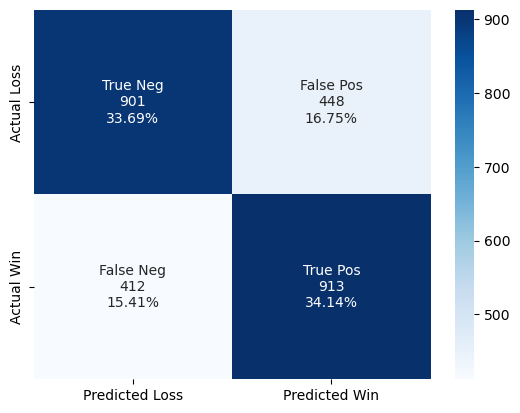

Area Under the Curve = 0.7386592444438228


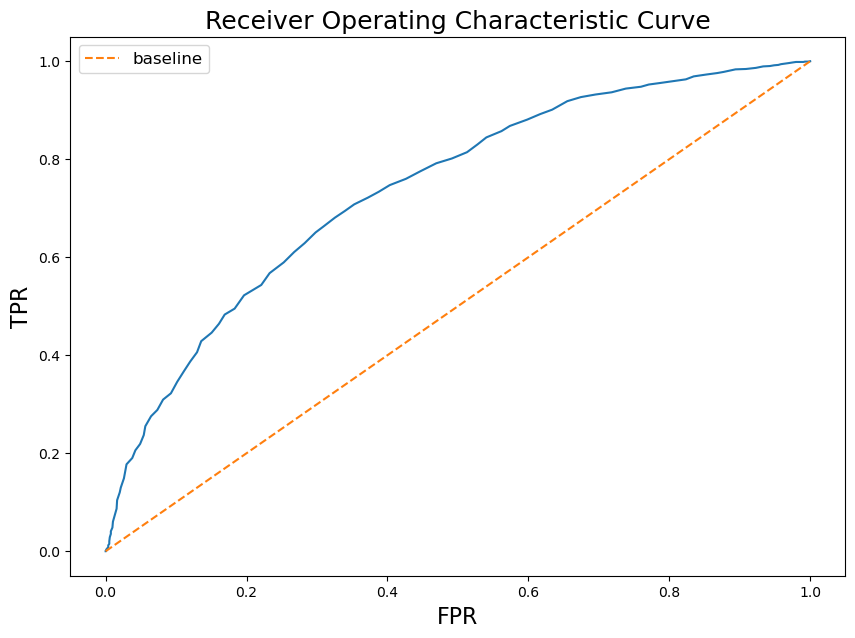

In [64]:
#evaluate trained logistic regression model on test data

evaluate_classification(logreg, X_test_full, y_test, extra = True)

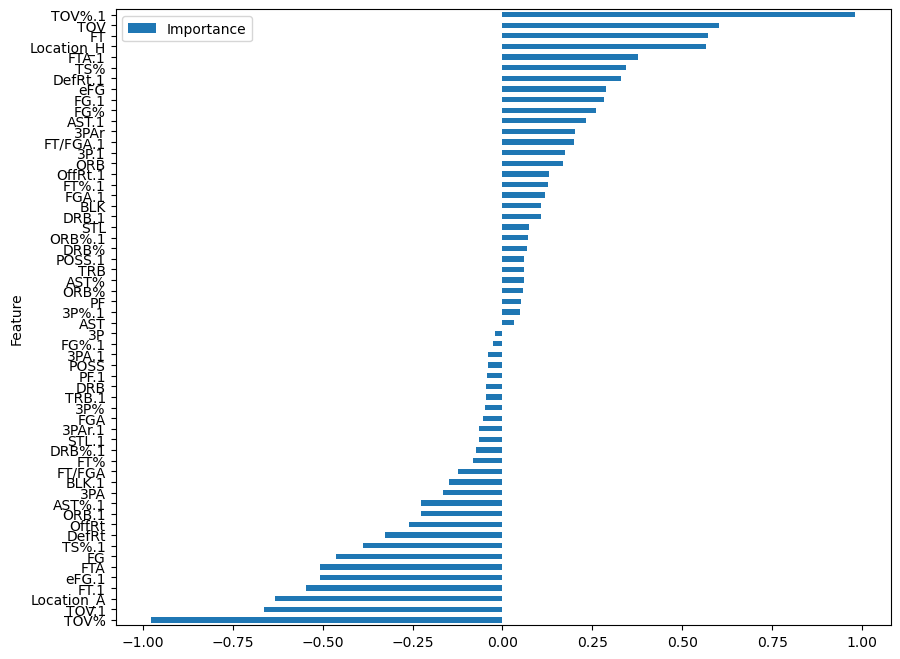

In [65]:
#examining variable importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [66]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
17        TOV%   -0.978235
42       TOV.1   -0.663499
56  Location_A   -0.633756
34        FT.1   -0.545128
44       eFG.1   -0.508619
7          FTA   -0.507788
0           FG   -0.461907
50       TS%.1   -0.387448
27       DefRt   -0.325657
26       OffRt   -0.259374
37       ORB.1   -0.226282
49      AST%.1   -0.225341
4          3PA   -0.164383
41       BLK.1   -0.147963
19      FT/FGA   -0.124808
8          FT%   -0.081576
48      DRB%.1   -0.073802
40       STL.1   -0.066192
51      3PAr.1   -0.064591
1          FGA   -0.053595
5          3P%   -0.048990
38       TRB.1   -0.046663
24         DRB   -0.044619
43        PF.1   -0.043326
25        POSS   -0.041289
32       3PA.1   -0.039750
30       FG%.1   -0.027295
3           3P   -0.020488
11         AST    0.032722
33       3P%.1    0.048923
15          PF    0.051739
18        ORB%    0.057907
21        AST%    0.059856
10         TRB    0.060305
53      POSS.1    0.060922
20        DRB%    0.068404
4

## Now lets use hyperopt to optimize the Logistic Regression

In [67]:
#create function to optimize
def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_full, y_train).mean()


In [68]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['lbfgs',
                                  'liblinear']),
    'C': hp.uniform('C', 0.001, 0.005),
    'max_iter': 5000,
    'random_state': 42,
}


In [69]:
#define the function that will run and what to output when new combinations of values produce better results
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}

#start the search
trials = Trials()
best = fmin(f, space, algo=anneal.suggest, max_evals=200, trials=trials)
print('best:')
print(best)

new best:                                                                       
0.6787610667654009                                                              
{'C': 0.004501842592640498, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
1                                                                               
new best:                                                                       
0.6788858328290316                                                              
{'C': 0.00401704230892268, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
8                                                                               
new best:                                                                       
0.679135209387635                                                               
{'C': 0.004513344153984871, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
14                                         

In [71]:
#examine best parameters
best_params = space_eval(space, best)
best_params

{'C': 0.004163479837560655,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs'}

In [72]:
best_hype = {'C': 0.004163479837560655,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs'}
best_hype

{'C': 0.004163479837560655,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs'}

In [73]:
#train model using best parameters from search
hyp_logreg = LogisticRegression(C = best_hype['C'],
                  #l1_ratio = best_params['l1_ratio'],
                  max_iter = best_hype['max_iter'],
                  penalty = best_hype['penalty'],
                  solver = best_hype['solver'],
                  random_state =  best_hype['random_state'])

hyp_logreg.fit(X_train_full, y_train)

LogisticRegression(C=0.004163479837560655, max_iter=5000, random_state=42)

In [74]:
#examine accuracy on training data
y_pred = hyp_logreg.predict(X_train_full)
print('Training Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3980
           1       0.68      0.68      0.68      4039

    accuracy                           0.68      8019
   macro avg       0.68      0.68      0.68      8019
weighted avg       0.68      0.68      0.68      8019



In [75]:
#examine accuracy on test data
y_pred = hyp_logreg.predict(X_test_full)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_test, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.67      0.68      1349
           1       0.67      0.69      0.68      1325

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6798803290949887 

Classification Report

              precision    recall  f1-score   support

           0     0.6860    0.6738    0.6799      1349
           1     0.6738    0.6860    0.6799      1325

    accuracy                         0.6799      2674
   macro avg     0.6799    0.6799    0.6799      2674
weighted avg     0.6800    0.6799    0.6799      2674



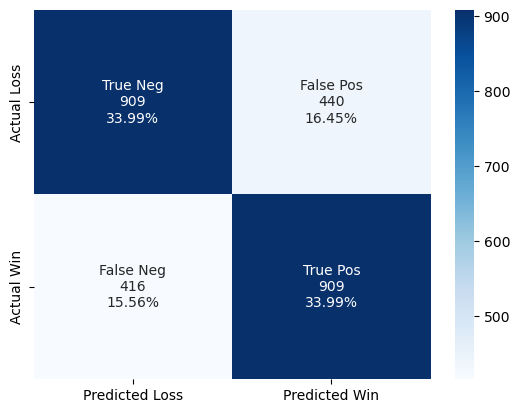

Area Under the Curve = 0.7433620991090536


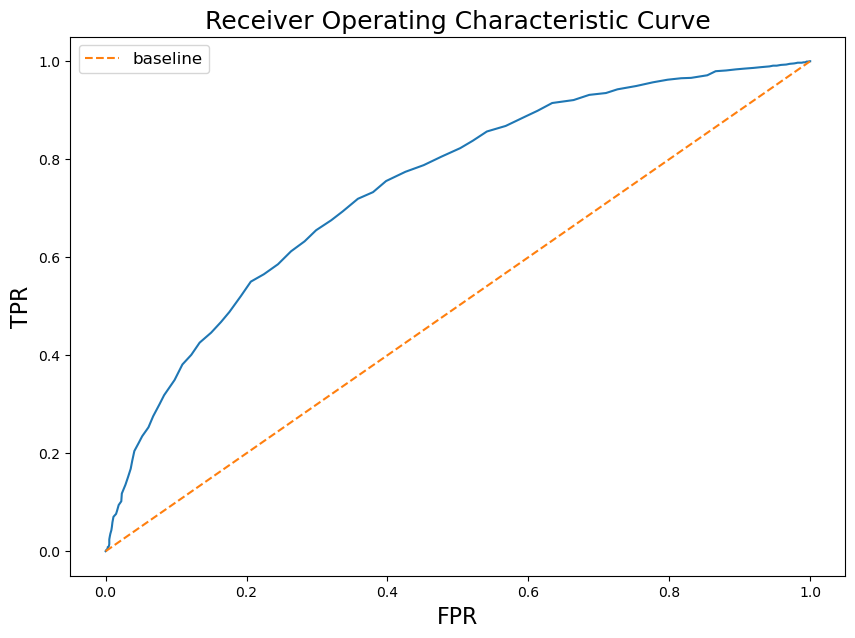

In [76]:
#further investigate accuracy on test data
evaluate_classification(hyp_logreg, X_test_full, y_test, extra = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

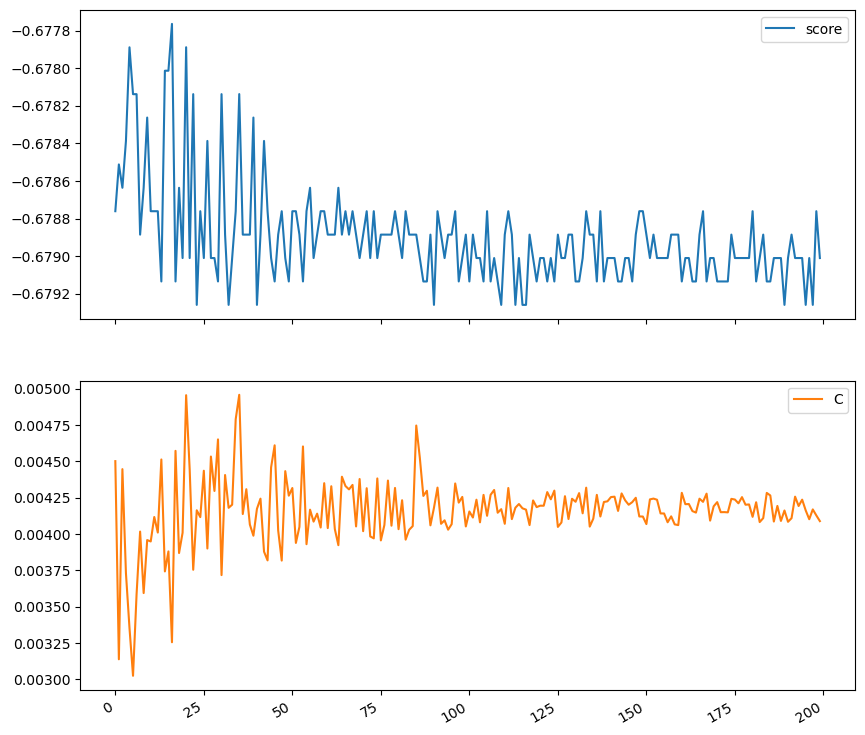

In [78]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

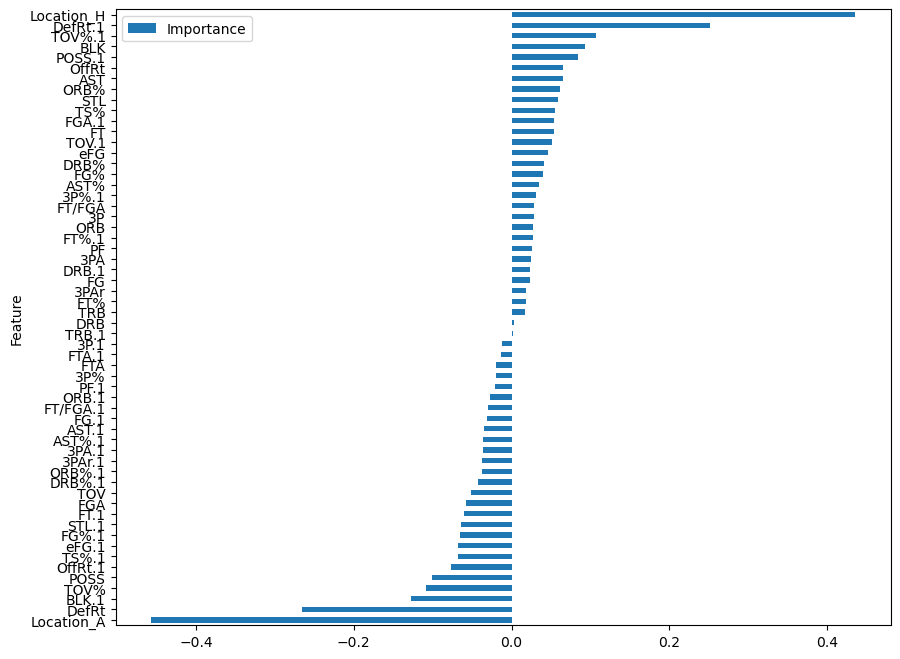

In [79]:
#examining variable importance
coefficients = hyp_logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [80]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
56  Location_A   -0.457268
27       DefRt   -0.266229
41       BLK.1   -0.126919
17        TOV%   -0.108020
25        POSS   -0.101194
54     OffRt.1   -0.076189
50       TS%.1   -0.068159
44       eFG.1   -0.067978
30       FG%.1   -0.064800
40       STL.1   -0.063636
34        FT.1   -0.060378
1          FGA   -0.058179
14         TOV   -0.051800
48      DRB%.1   -0.041946
46      ORB%.1   -0.037569
51      3PAr.1   -0.037262
32       3PA.1   -0.036341
49      AST%.1   -0.036101
39       AST.1   -0.034472
28        FG.1   -0.030618
47    FT/FGA.1   -0.029662
37       ORB.1   -0.027577
43        PF.1   -0.021128
5          3P%   -0.020198
7          FTA   -0.019696
35       FTA.1   -0.013913
31        3P.1   -0.012269
38       TRB.1    0.001893
24         DRB    0.002511
10         TRB    0.016903
8          FT%    0.017914
23        3PAr    0.018112
0           FG    0.022768
52       DRB.1    0.023606
4          3PA    0.024184
15          PF    0.025727
3

In [81]:
#compare original logistic regression to optimized
compare_classification(logreg, hyp_logreg, X_test_full, X_test_full, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6783844427823486     0.6798803290949887     0.0014958863126401933      Accuracy: Model 2 better
AUC:  0.7386592444438228     0.7433620991090536     0.004702854665230793      AUC: Model 2 better


## The optimized model performs better than the base model

## It may be the case that some variables are not that important, as a result we can try using Recrusive Feature Selection to narrow down our variable list

In [82]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
LR_estimator = LogisticRegression(random_state=42, max_iter = 5000)
LR_select = RFECV(LR_estimator, step=1, cv=5, n_jobs = -1)
LR_selector = LR_select.fit(X_train_full, y_train)


In [83]:
#examining how many of the original features were retained
(LR_selector.support_).sum()

34

In [84]:
#examining which features were retained
X_train_full.columns[LR_selector.support_]

Index(['FG', 'FG%', '3PA', 'FT', 'FTA', 'ORB', 'TOV', 'TOV%', 'FT/FGA', 'AST%',
       'TS%', '3PAr', 'OffRt', 'DefRt', 'FG.1', '3P.1', 'FT.1', 'FTA.1',
       'FT%.1', 'ORB.1', 'AST.1', 'BLK.1', 'TOV.1', 'eFG.1', 'TOV%.1',
       'FT/FGA.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H'],
      dtype='object')

In [85]:
#examining which features were removed
X_train_full.columns[~LR_selector.support_]

Index(['FGA', '3P', '3P%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'eFG',
       'ORB%', 'DRB%', 'DRB', 'POSS', 'FGA.1', 'FG%.1', '3PA.1', '3P%.1',
       'TRB.1', 'STL.1', 'PF.1', 'ORB%.1', 'DRB%.1', 'POSS.1'],
      dtype='object')

In [86]:
#creating training data the contains only the retained features
X_train_std_sub = X_train_full[X_train_full.columns[LR_selector.support_]]
X_test_std_sub = X_test_full[X_train_full.columns[LR_selector.support_]]

In [87]:
#creating a base logistic regression object
logreg_sub = LogisticRegression(random_state = 42, max_iter = 5000)

In [88]:
#fitting the model to the subset of features
logreg_sub.fit(X_train_std_sub, y_train)

LogisticRegression(max_iter=5000, random_state=42)

Model Performance

Accuracy =  0.6705310396409873 

Classification Report

              precision    recall  f1-score   support

           0     0.6775    0.6620    0.6697      1349
           1     0.6637    0.6792    0.6714      1325

    accuracy                         0.6705      2674
   macro avg     0.6706    0.6706    0.6705      2674
weighted avg     0.6707    0.6705    0.6705      2674



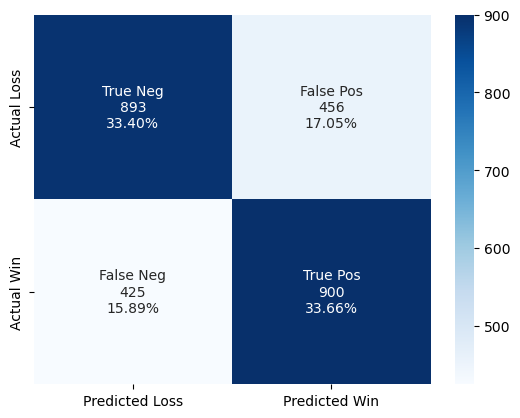

Area Under the Curve = 0.7344313747429962


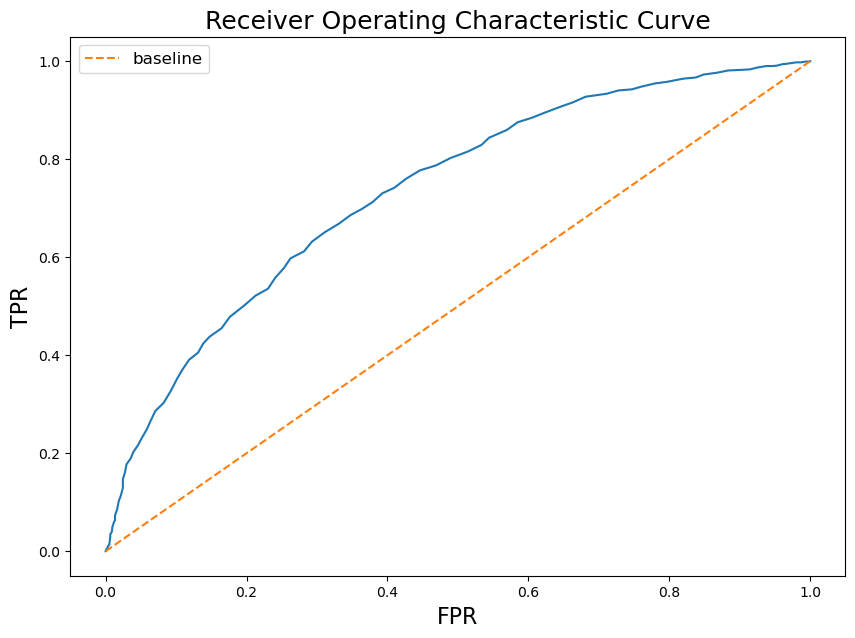

In [89]:
#evaluating reduced features model
evaluate_classification(logreg_sub, X_test_std_sub, y_test, extra = True)

In [90]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, logreg_sub, X_test_full, X_test_std_sub, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6798803290949887     0.6705310396409873     -0.009349289454001486      Accuracy: Model 1 better
AUC:  0.7433620991090536     0.7344313747429962     -0.008930724366057352      AUC: Model 1 better


## The optimized base full variable set model performs better
## Lets also try optimizing the RFE model

In [92]:
def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_std_sub, y_train).mean()


In [93]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['saga',
                                   'liblinear',
                                  'lbfgs',
                                  'sag']),
    'C': hp.uniform('C', 0.0,1.0),
    'max_iter': 5000,
    'random_state': 42,
}


In [95]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=500, trials=trials)
print('best:')
print(best)

new best:                                                                       
0.6740229899362636                                                              
{'C': 0.20685493865537652, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
1                                                                               
new best:                                                                       
0.6770154308551766                                                              
{'C': 0.006970405022397541, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag'}
2                                                                               
new best:                                                                       
0.6780124703836167                                                              
{'C': 0.0029944417578937335, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
25                                          

In [96]:
#examine best parameters
best_params = space_eval(space, best)
best_params

{'C': 0.0015594564112270115,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}

In [97]:
best2 = {'C': 0.0015594564112270115,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}
best2

{'C': 0.0015594564112270115,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}

In [98]:
#train model using best parameters
hyp_rfe = LogisticRegression(C = best2['C'],
                  max_iter = best2['max_iter'],
                  penalty = best2['penalty'],
                  solver = best2['solver'],
                  random_state =  best2['random_state'])

hyp_rfe.fit(X_train_std_sub, y_train)

LogisticRegression(C=0.0015594564112270115, max_iter=5000, random_state=42,
                   solver='liblinear')

In [99]:
y_pred = hyp_rfe.predict(X_train_std_sub)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.67      0.68      3980
           1       0.68      0.68      0.68      4039

    accuracy                           0.68      8019
   macro avg       0.68      0.68      0.68      8019
weighted avg       0.68      0.68      0.68      8019



In [100]:
y_pred = hyp_rfe.predict(X_test_std_sub)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_test, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.67      0.67      1349
           1       0.67      0.68      0.67      1325

    accuracy                           0.67      2674
   macro avg       0.67      0.67      0.67      2674
weighted avg       0.67      0.67      0.67      2674



Model Performance

Accuracy =  0.6735228122662678 

Classification Report

              precision    recall  f1-score   support

           0     0.6798    0.6672    0.6734      1349
           1     0.6674    0.6800    0.6736      1325

    accuracy                         0.6735      2674
   macro avg     0.6736    0.6736    0.6735      2674
weighted avg     0.6736    0.6735    0.6735      2674



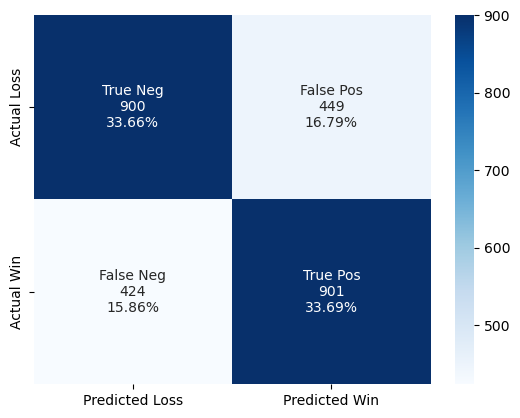

In [101]:
evaluate_classification(hyp_rfe, X_test_std_sub, y_test)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

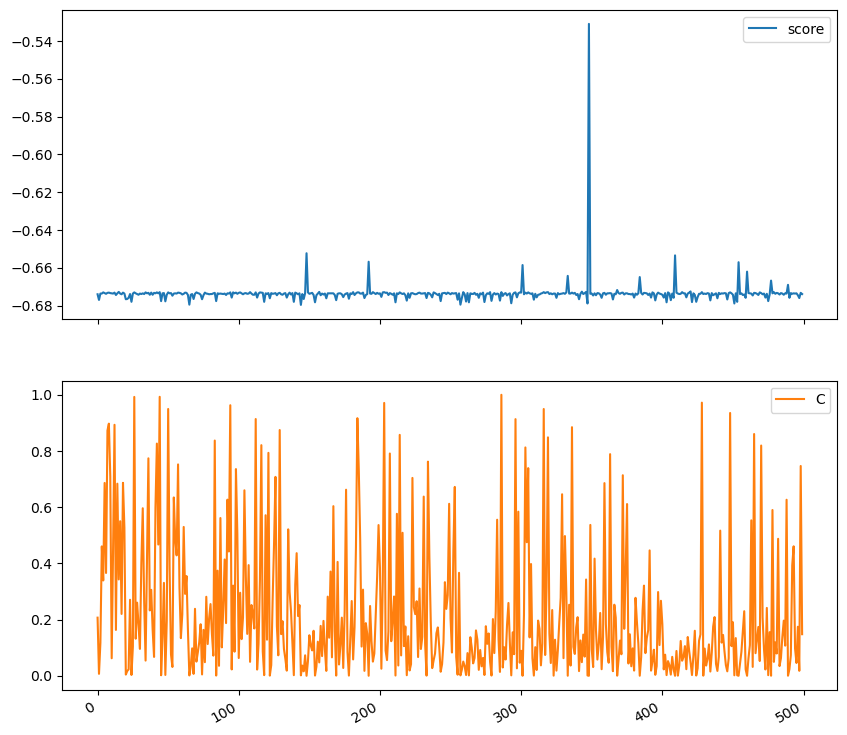

In [102]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

In [103]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, hyp_rfe, X_test_full, X_test_std_sub, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6798803290949887     0.6735228122662678     -0.006357516828720988      Accuracy: Model 1 better
AUC:  0.7433620991090536     0.7387135124550681     -0.004648586653985487      AUC: Model 1 better


## The optimized logistic regression model still performs the best

## Next notebook will explore using a Gradient boosting model

In [ ]:
#saving best model results here
best_hype = {'C': 0.004163479837560655,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs'}

#train model using best parameters from search
hyp_logreg = LogisticRegression(C = best_hype['C'],
                  #l1_ratio = best_params['l1_ratio'],
                  max_iter = best_hype['max_iter'],
                  penalty = best_hype['penalty'],
                  solver = best_hype['solver'],
                  random_state =  best_hype['random_state'])

hyp_logreg.fit(X_train_full, y_train)

